###  Importing Library

In [27]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


#### Hyperparameters

In [28]:
batch_size = 64
image_size = 64       # resolusi gambar (64x64)
nz = 100              # dimensi vektor noise (input generator)
num_epochs =  150        # silakan disesuaikan
lr = 0.0002
beta1 = 0.5
ngf = 64  # generator feature map size
ndf = 64  # discriminator feature map size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Memeriksa apakah CUDA tersedia
print(torch.cuda.is_available())

# Jika True, berarti GPU Anda bisa digunakan oleh PyTorch
# Nama GPU (untuk device index 0)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    print(torch.version.cuda)


True
NVIDIA GeForce GTX 1060 6GB
11.8


#### Persiapan Dataset & DataLoader

In [29]:
data_dir = r"C:\Users\dawwi\Downloads\Dataset"  # ganti dengan path dataset Anda

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # normalisasi [-1, 1]
])

dataset = torchvision.datasets.ImageFolder(
    root=data_dir,
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

#### Definisi Arsitektur DCGAN

In [30]:
# Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc=3):
        """
        nz : ukuran noise vector
        ngf: ukuran base feature di generator
        nc : jumlah channel pada output (3 untuk RGB)
        """
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input Z berukuran nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # state size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # state size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # state size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # state size: (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 64 x 64
        )

    def forward(self, x):
        return self.main(x)

In [31]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, ndf, nc=3):
        """
        ndf: ukuran base feature di discriminator
        nc : jumlah channel input (3 untuk RGB)
        """
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input size: (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # state size: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # output shape: 1
        )

    def forward(self, x):
        return self.main(x)

# Inisialisasi model
netG = Generator(nz, ngf).to(device)
netD = Discriminator(ndf).to(device)

#### Loss function & Optimizer

In [32]:
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

#### Training

In [33]:
lossD_history = []
lossG_history = []

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# label real dan fake
real_label = 1.
fake_label = 0.

# Simpan sample G setiap epoch
os.makedirs("samples", exist_ok=True)

print("Start Training...")
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        # ----------------------
        # 1) Update D
        # ----------------------
        netD.zero_grad()

        # Train with real
        real_imgs = imgs.to(device)
        b_size = real_imgs.size(0)

        label_real = torch.full((b_size,), 1., dtype=torch.float, device=device)
        label_fake = torch.full((b_size,), 0., dtype=torch.float, device=device)

        output_real = netD(real_imgs).view(-1)
        lossD_real = criterion(output_real, label_real)

        # Train with fake
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_imgs = netG(noise)

        output_fake = netD(fake_imgs.detach()).view(-1)
        lossD_fake = criterion(output_fake, label_fake)

        lossD_total = lossD_real + lossD_fake
        lossD_total.backward()
        optimizerD.step()

        # ----------------------
        # 2) Update G
        # ----------------------
        netG.zero_grad()
        # Generator wants D(G(z)) = 1
        output_fake_for_G = netD(fake_imgs).view(-1)
        lossG_total = criterion(output_fake_for_G, label_real)
        lossG_total.backward()
        optimizerG.step()

        # Simpan history loss (opsional: per batch, atau rata2 per epoch)
        lossD_history.append(lossD_total.item())
        lossG_history.append(lossG_total.item())

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] "
                  f"LossD: {lossD_total.item():.4f} LossG: {lossG_total.item():.4f}")

    # Simpan sample images di akhir epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    grid = make_grid(fake, nrow=8, normalize=True)
    save_image(grid, f"samples/epoch_{epoch+1}.png")
    print(f"Sample image saved: samples/epoch_{epoch+1}.png")

print("Training Finished.")

Start Training...
Epoch [1/50] Batch [0/2290] LossD: 1.4571 LossG: 2.8017
Epoch [1/50] Batch [100/2290] LossD: 1.0638 LossG: 1.7012
Epoch [1/50] Batch [200/2290] LossD: 0.5983 LossG: 3.7875
Epoch [1/50] Batch [300/2290] LossD: 0.6501 LossG: 3.1395
Epoch [1/50] Batch [400/2290] LossD: 0.6678 LossG: 2.7676
Epoch [1/50] Batch [500/2290] LossD: 0.5992 LossG: 3.2668
Epoch [1/50] Batch [600/2290] LossD: 0.6610 LossG: 2.7770
Epoch [1/50] Batch [700/2290] LossD: 0.5958 LossG: 4.8751
Epoch [1/50] Batch [800/2290] LossD: 0.4664 LossG: 4.7579
Epoch [1/50] Batch [900/2290] LossD: 0.4602 LossG: 4.0127
Epoch [1/50] Batch [1000/2290] LossD: 0.7898 LossG: 1.8462
Epoch [1/50] Batch [1100/2290] LossD: 2.2126 LossG: 3.2092
Epoch [1/50] Batch [1200/2290] LossD: 1.1797 LossG: 6.9070
Epoch [1/50] Batch [1300/2290] LossD: 0.3788 LossG: 5.7417
Epoch [1/50] Batch [1400/2290] LossD: 0.4160 LossG: 4.5186
Epoch [1/50] Batch [1500/2290] LossD: 0.5920 LossG: 4.9465
Epoch [1/50] Batch [1600/2290] LossD: 0.7001 LossG

### Plot Training Loss

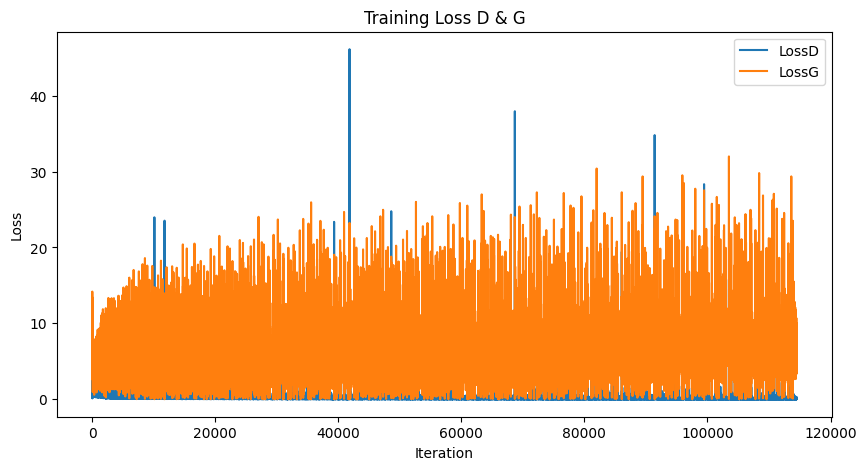

Plot saved: training_loss_plot.png


In [34]:
plt.figure(figsize=(10,5))
plt.title("Training Loss D & G")
plt.plot(lossD_history, label="LossD")
plt.plot(lossG_history, label="LossG")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.savefig("training_loss_plot.png")
plt.show()
print("Plot saved: training_loss_plot.png")

### Evaluasi FID (NOT USE FOR NOW)

In [35]:
# # Contoh cara menghitung FID menggunakan pytorch-fid:
# #
# # 1) Install pytorch-fid:
# #    pip install pytorch-fid
# # 2) Generate sejumlah fake images, simpan di folder khusus
# #    Kumpulkan juga real images di folder lain.
# # 3) Jalankan:
# #    python -m pytorch_fid path/to/real_images path/to/fake_images
# #
# # Di bawah ini contoh kode untuk simpan fake images & real images.
#
# def save_fake_images_for_fid(generator, save_dir="fake_for_fid", num_images=500):
#     os.makedirs(save_dir, exist_ok=True)
#     generator.eval()
#     with torch.no_grad():
#         for idx in range(num_images):
#             z = torch.randn(1, nz, 1, 1, device=device)
#             fake = generator(z).cpu()
#             # Normal range is [-1,1], convert to [0,1]
#             fake = (fake + 1)/2
#             fake_clamped = torch.clamp(fake, 0, 1)
#             save_image(fake_clamped, os.path.join(save_dir, f"fake_{idx}.png"))
#
# def save_real_images_for_fid(dataset, save_dir="real_for_fid", num_images=500):
#     os.makedirs(save_dir, exist_ok=True)
#     count = 0
#     for i, (img, _) in enumerate(dataset):
#         if count >= num_images:
#             break
#         # convert [-1,1] or [0,1] -> [0,1] (tergantung transform)
#         # Saat ini dataset di-normalize ke [-1,1] => kita kembalikan
#         img = (img * 0.5) + 0.5
#         img = torch.clamp(img, 0, 1)
#         # unsqueeze batch dimension
#         save_image(img, os.path.join(save_dir, f"real_{count}.png"))
#         count += 1
#
# # Cara penggunaannya (uncomment jika ingin pakai):
# # save_fake_images_for_fid(netG, "fake_for_fid", num_images=200)
# # save_real_images_for_fid(dataset, "real_for_fid", num_images=200)
# #
# # Setelah folder "fake_for_fid" dan "real_for_fid" terisi, jalankan di Terminal:
# #    python -m pytorch_fid real_for_fid fake_for_fid
#
# # -------------------------------------------------------------
# # Bagian 7: Visualisasi Latent Space (t-SNE) [Opsional]
# # -------------------------------------------------------------
# # Kadang kita ingin melihat sebaran vektor noise (z).
# # t-SNE bermanfaat jika kita punya label (tapi di DCGAN unlabeled).
# # Berikut contoh minimal:
#
# """
# from sklearn.manifold import TSNE
# import numpy as np
#
# def visualize_latent_tsne(num_samples=500):
#     # Kita sampling z random, lalu project ke 2D
#     netG.eval()
#     all_z = []
#     for _ in range(num_samples):
#         z = torch.randn(1, nz, 1, 1, device=device)
#         all_z.append(z.view(1, -1).cpu().numpy())  # (1, nz)
#     all_z = np.concatenate(all_z, axis=0)  # shape (num_samples, nz)
#
#     tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
#     z_2d = tsne.fit_transform(all_z)
#
#     plt.figure(figsize=(8,6))
#     plt.scatter(z_2d[:,0], z_2d[:,1], alpha=0.7, s=10, c='blue')
#     plt.title("t-SNE of Random Noise Z (DCGAN)")
#     plt.xlabel("Dimension 1")
#     plt.ylabel("Dimension 2")
#     plt.show()
#
# # Jalankan jika mau:
# # visualize_latent_tsne()
# """

### Visualisasi Latent Space (t-SNE)

In [36]:
def visualize_latent_tsne(modelG, num_samples=500):
    """
    Fungsi ini mengambil 'num_samples' random noise,
    lalu memplot distribusinya di 2D dengan TSNE.
    """
    modelG.eval()
    all_z = []
    for _ in range(num_samples):
        z = torch.randn(1, nz, 1, 1, device=device)  # (1, nz, 1, 1)
        # Flatten (1, nz*1*1) => (1, nz)
        all_z.append(z.view(1, -1).cpu().numpy())
    all_z = np.concatenate(all_z, axis=0)  # (num_samples, nz)

    print("Running t-SNE on latent vectors. Might take a while ...")
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
    z_2d = tsne.fit_transform(all_z)

    plt.figure(figsize=(8,6))
    plt.scatter(z_2d[:,0], z_2d[:,1], alpha=0.7, s=10, c='blue')
    plt.title("t-SNE of Random Noise Z (DCGAN)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.show()

    print("t-SNE plot displayed above.")

#### Saving Model

In [37]:
def save_dcgan_models(netG, netD, i):
    """
    Menyimpan model generator & discriminator DCGAN
    dengan nama file Model_DCGAN_Ver_(i+i).pth.

    Parameter:
    - netG: model Generator
    - netD: model Discriminator
    - i   : angka versi (integer)
    """
    # Pastikan folder "saved_models" (atau nama lain) ada
    os.makedirs("saved_models", exist_ok=True)

    # Format penamaan file
    generator_filename = f"Model_DCGAN_Gen_Ver_{i+i}.pth"
    discriminator_filename = f"Model_DCGAN_Dis_Ver_{i+i}.pth"

    # Lokasi file (gabungkan dengan folder "saved_models")
    generator_path = os.path.join("saved_models", generator_filename)
    discriminator_path = os.path.join("saved_models", discriminator_filename)

    # Simpan state_dict model
    torch.save(netG.state_dict(), generator_path)
    torch.save(netD.state_dict(), discriminator_path)

    print(f"Generator DCGAN disimpan di: {generator_path}")
    print(f"Discriminator DCGAN disimpan di: {discriminator_path}")

# -------------------------------------------------------------
# Contoh penggunaan di luar training
# -------------------------------------------------------------
# Misal Anda sudah selesai training netG dan netD.
# Anggap 'netG' dan 'netD' adalah instance dari Generator & Discriminator
# DCGAN yang telah dilatih.

# Contoh saja, misalnya versi i=5
i = 5

# Panggil fungsi penyimpanan
save_dcgan_models(netG, netD, i)

Generator DCGAN disimpan di: saved_models\Model_DCGAN_Gen_Ver_10.pth
Discriminator DCGAN disimpan di: saved_models\Model_DCGAN_Dis_Ver_10.pth
